# Image Classification using Convolutional Neural Networks

In this notebook, you will work again on the CIFAR-10 classification task. This time a standard approach to the image classification  - namely Convolutional Neural Networks - will be applied.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
from keras.utils import np_utils
from keras.utils.layer_utils import count_params
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras import layers
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

Using TensorFlow backend.


![title](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

We defined to plotting functions for you which can be used in this (and other) notebooks. The first one plots a confustion matrix. The second one plots the training history.

In [3]:
def plot_cm(y_true, y_pred, classlabels=None,ax=None, xlabel='predicted class',ylabel='actual class',cmtitle='Confusion Matrix'):
    if ax is None:
        fig,ax = plt.subplots()
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot=True, fmt="d",cmap=sns.color_palette("Blues"),ax=ax)
    if classlabels is not None:
        ax.set(xticklabels=classlabels)
        ax.set(yticklabels=classlabels)
    ax.set(xlabel=xlabel)
    ax.set(ylabel=ylabel)
    ax.set(title=cmtitle)

In [4]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None,monitor='val_loss', mode='min',plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

We use the same dataset as in the last notebook and - due to computation time - you are again free to choose which fraction of the data you want to use.

In [5]:
(X_train, y_train), (X_test,y_test) = cifar10.load_data()
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))
classlabels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog','horse','boat','truck']
#only take a fourth of the dataset, i.e. the first fold
dataset_split = 4
skf = StratifiedKFold(n_splits=dataset_split,shuffle=True,random_state=42)
for train_index, test_index in skf.split(X,y):
    X = X[test_index]
    y = y[test_index]
    break
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.33, random_state=42)

In [6]:
# convert the images to floats between 0 and 1
X_train, X_test = X_train.astype('float32')/255, X_test.astype('float32')/255
# convert the labels to one-hot encoding
(y_train, y_test)=  np_utils.to_categorical(y_train,10), np_utils.to_categorical(y_test,10)
# mean center the images
X_train_mean = np.expand_dims(X_train.mean(axis=0),axis=0)
X_train = X_train-X_train_mean
X_test = X_test-X_train_mean

CNNs use similar/same concepts as the convolution you might know from your signal processing or computer vision courses. When dealing with a 2D array we could convolve an grey scale image with a 2D filter. In most cases though we are working on colored images. In CNNs this fact is handeled by using a filter kernel for each channel. So an image is of size $H_I$x$W_I$x$3$ and the kernel of size $H_k$x$W_k$x$3$. After 3 2D-convolutions the result is finally summed up, such that the output is of dimension $H_O$x$W_O$x$1$. The spatial dimensions depend on the padding you apply. In CNN a bias would be added subsequently to the 3 convolutions and summation and finally the output would be passed through an activation function.

__Task:__ Implement a vertical sobel filter and apply this filter to each color channel of all images in training and test set. Use SciPy's `ndimage.convolve()` function with `mode='constant'` and `cval=0.0`
. Add up the results of all 3 channels after convolution and call it *X_train_conv* and *X_test_conv* respectively.

In [7]:
from scipy import ndimage
kernel = np.array([[-1, -2, -1],[0,0,0],[1,2,1]])
X_train_conv = np.empty(X_train.shape[:-1])
X_test_conv = np.empty(X_test.shape[:-1])
for k in range(len(X_train)): 
    X_train_conv[k,:,:] = ndimage.convolve(X_train[k,:,:,0], kernel, mode='constant', cval=0.0)+ndimage.convolve(X_train[k,:,:,1], kernel, mode='constant', cval=0.0)+ndimage.convolve(X_train[k,:,:,2], kernel, mode='constant', cval=0.0)
for k in range(len(X_test)): 
    X_test_conv[k,:,:] = ndimage.convolve(X_test[k,:,:,0], kernel, mode='constant', cval=0.0)+ndimage.convolve(X_test[k,:,:,1], kernel, mode='constant', cval=0.0)+ndimage.convolve(X_test[k,:,:,2], kernel, mode='constant', cval=0.0)

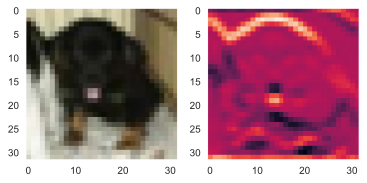

In [8]:
f,ax = plt.subplots(1,2)
ax[0].imshow(X_train[10]+np.squeeze(X_train_mean))
ax[0].grid(False)
ax[1].imshow(X_train_conv[10])
ax[1].grid(False)

Ok lets do a short experiment. Check if the filtered images can be used in feed forward network. We used a sobel filter in each channel. In contrast a CNN would learn its filter coefficients, let us check if this works better.

__Task:__ Complete the two networks below with dense layers. Train the models and check of the learned filer is superior to the sobel filter in terms of test-accuracy!

_Remark:_ For the `Conv2D()` layer below, we use the number of filters to be 1, `padding='same'`, `activation=None` and `use_bias=False`. This ensures a fair comparison. In the summary you can see, that the network will have  to learn 27 parameters more than one with the sobel input. This is 3 times 3 for each kernel times 3 channels.

In [9]:
def build_model_sobel():
    nn = Sequential()
    nn.add(Flatten(input_shape=X_train_conv.shape[1:]))
    nn.add(Dense(512,activation='relu',name="hidden1"))
    nn.add(Dense(64,activation='relu',name="hidden2"))
    nn.add(Dense(10, activation='softmax'))
    #Compile mlp
    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn
def build_model_learn():
    nn = Sequential()
    nn.add(Conv2D(1,(3,3),activation=None,input_shape=X_train.shape[1:],padding='same', use_bias=False))
    nn.add(Flatten())
    nn.add(Dense(512,activation='relu',name="hidden1"))
    nn.add(Dense(64,activation='relu',name="hidden2"))
    nn.add(Dense(10, activation='softmax'))
    #Compile mlp
    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn

In [10]:
model = build_model_sobel()
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
history = model.fit(X_train_conv, y_train, validation_split=0.2, 
                    epochs=50, batch_size=64, callbacks=[es], verbose=0)
model.evaluate(X_test_conv, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               524800    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 558,282
Trainable params: 558,282
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping
4950/4950 [==============================] - 0s 75us/step


[2.0604831357435747, 0.2781818211078644]

In [11]:
model = build_model_learn()
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, 
                    epochs=50, batch_size=64, callbacks=[es], verbose=0)
model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 1)         27        
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               524800    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 558,309
Trainable params: 558,309
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch
Epoch 00010: early stopping
4950/4950 [====================

[1.8025371898304332, 0.36606061458587646]

Ok, after warm up we now want to build a CNN to classify the CIFAR images. 

![title](https://deepsea.ldv.ei.tum.de/seafhttp/files/7474addd-dd54-46ba-b629-85e4656d594b/cnn.png)

**Task**: Write a `build_model()` function that returns a Keras sequential model suited for 10-class classification (right number of in/outputs). Use an alternation of 2D convolutional layers and pooling layers (keep it at 3 and 2 layers of each). Use a filtersize of 5 and 3 and the number of filters of 32 and 64. Add the parameter `name='conv1'`,`name='conv2'` and `name='conv3'` to the `Conv2D()` layers - we will use that later on.
On top, add a flatten layer and connect one dense hidden layer and the dense output layer. Check your model using `model.summary()`. 

In [12]:
def build_model():
    cnn = Sequential()
    cnn.add(Conv2D(32,(5,5), activation='relu', input_shape=(32, 32, 3),name='conv1'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu', name='conv2'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu', name='conv3'))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(10, activation='softmax'))
    #Compile mlp
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

Train your model on the dataset with early stopping (using a sensible validation split). Plot the accuracy and the loss during the training and a confusion matrix on test and training set. 

In [13]:
model = build_model()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch
Epoch 00015: early stopping


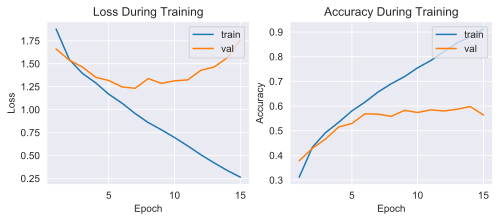

In [14]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_model_history(history, ax=ax[0])
plot_model_history(history, metric='accuracy',ax=ax[1])

4950/4950 [==============================] - 2s 390us/step


[1.208339219526811, 0.5703030228614807]

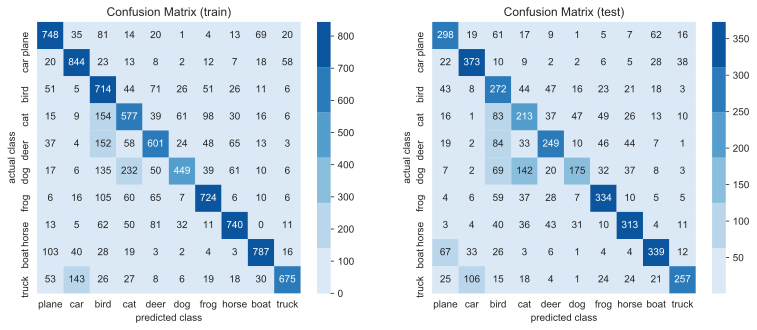

In [15]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=(13,5))
plot_cm(y_train.argmax(axis=1),y_train_pred.argmax(axis=1), ax=ax[0],classlabels=classlabels,cmtitle='Confusion Matrix (train)')
plot_cm(y_test.argmax(axis=1),y_test_pred.argmax(axis=1), ax=ax[1],classlabels=classlabels, cmtitle='Confusion Matrix (test)')
model.evaluate(X_test,y_test)

Count the trainable parameters of your model.
__Task:__ Build a feedforward with 2 hidden layers and a similar amount of parameters. Play around with the size factor, if you found a model with a similar number of parameters, train it and compare the results!

In [16]:
print('Trainable parameters CNN: ' + str(count_params(model.trainable_weights)))
def build_model_mlp(size_fac=1):
    mlp = Sequential()
    mlp.add(Flatten(input_shape=(X_train.shape[1:])))
    mlp.add(Dense(int(size_fac*3),activation='relu',name="hidden1"))
    mlp.add(Dense(int(size_fac*2), activation='relu',name="hidden2"))
    mlp.add(Dense(10, activation='softmax',name="output"))
    mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mlp
mlp = build_model_mlp(21)
print('Trainable parameters MLP: ' + str(count_params(mlp.trainable_weights)))

Trainable parameters CNN: 190346
Trainable parameters MLP: 196717


In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
history = mlp.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[es], verbose=0)
print('CNN', model.evaluate(X_test,y_test))
print('MLP',mlp.evaluate(X_test,y_test))

Restoring model weights from the end of the best epoch
Epoch 00013: early stopping
4950/4950 [==============================] - 2s 406us/step
CNN [1.208339219526811, 0.5703030228614807]
4950/4950 [==============================] - 0s 82us/step
MLP [1.693477537367079, 0.4183838367462158]


Can we get an idea what a CNN learns? To get an intuation we will do two things: First, we will inspect some activations in different layers. Therefore we just interpret the output of our convolutional layers as images. 
    A more sophisticated visualization can be done by learning which images maximize the activations.
    
__Task:__ Use the cells below to play around and visually inspect the activations of different layers!

In [18]:
layer_name = 'conv1' ## change the layer

layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_output = layer_dict[layer_name].output
activation_model = Model(inputs=model.input, outputs=layer_output) 
activations = activation_model.predict(X_test) 

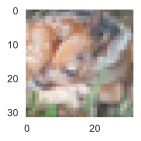

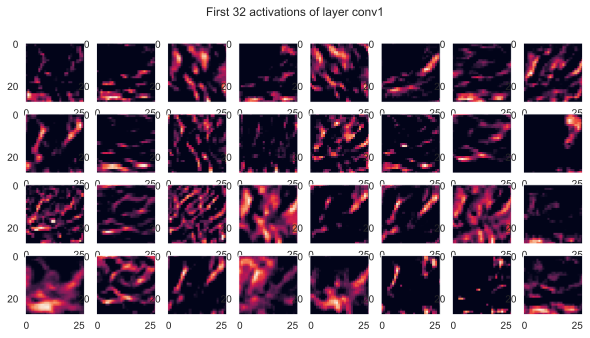

In [19]:
picnb = 100  # change the picture in the training set
f = plt.figure(figsize=[2,2])
plt.imshow(X_test[picnb,:,:,:] + np.squeeze(X_train_mean))
plt.grid(False)
f,axs = plt.subplots(4,8,figsize=[10,5])
for fnb,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(activations[picnb,:,:,fnb])
    ax.grid(False)
plt.suptitle('First 32 activations of layer ' + layer_name)
plt.show()

Now we inspected the activations of the CNN layers for natural images from our test set. Even more interesting might be how an image has to look like to maximize the output of a filter. This is only slightly more complcated than plotting the activations. Basically we start with a black image and change the pixel intensities in a way to maximize the output of a filter. This is called "gradient ascent". The functions below will do the job for you. It is taken (and only slightly adopted) from the [Keras Documentation](https://keras.io/examples/conv_filter_visualization/).

In [20]:
from __future__ import print_function
import time
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import backend as K

In [21]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [22]:
def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [23]:
def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()

In [24]:
def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calculate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('cnn_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

Lets call the function and see what we get. 
_Remark:_ Sometimes the gradient ascent does not converge, so we do not get an image in this case. Also note that the images are put into a rectangular grid and only the best filters will bei included. The resulting image will be saved to disk. Of course you are free to change this behaviour.

In [25]:
visualize_layer(model, 'conv3')

Compute filters 0 to 64
Costs of filter   3:   148 ( 7.80s )
Costs of filter   5:    58 ( 8.71s )
Costs of filter   7:    58 ( 7.95s )
Costs of filter   9:    80 ( 7.22s )
Costs of filter  15:   118 ( 7.22s )
Costs of filter  17:   180 ( 7.29s )
Costs of filter  18:    85 ( 7.07s )
Costs of filter  21:   113 ( 6.99s )
Costs of filter  32:   113 ( 7.17s )
Costs of filter  36:    59 ( 7.11s )
Costs of filter  37:    46 ( 7.17s )
Costs of filter  41:    64 ( 7.25s )
Costs of filter  47:    77 ( 7.08s )
Costs of filter  52:    86 ( 7.20s )
Costs of filter  55:   134 ( 7.23s )
Costs of filter  58:   146 ( 7.26s )
Costs of filter  60:   133 ( 7.23s )
Costs of filter  62:    51 ( 7.28s )
18 filter processed.
